# Part 2: Extensions to Basic Cellular Automata

In this part of the tutorial, we look at ways to expand upon the cellular automata model, and to make the model more expressive. In the original version, in keeping with Conway's Game of Life, we made many assumptions including deterministic behavior, synchronous updates, and cells that could live indefinitely. In this section we examine each of these assumptions and how to go forego them, in an attempt to more closely mimic characteristics a real population might have.

## 2.1 Asynchronous Updates

Unlike the original model we developed in section 1, we now explore asynchronous updates to the grid world. This means that instead of updating states as a function of only the previous state, we now update the cells in-place as a function of all prior updates, updating one cell at a time and allowing that to affect subsequent updates. This method of updating the states of cells may better mimic a real population because a whole population doesn't have all births and deaths occur so simultaneously, and instead one death or birth may affect other processes.

To do this, first we keep most of the functions the same from the last version, which is shown below for use in this notebook as well as for your reference.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import random
from itertools import product

ALIVE = 1
DEAD = 0

def init_world(n = 16, cluster_n = 4, clusters = 3, threshold = 0.25):
    world = np.zeros((n, n), dtype=int)

    for i in range(0, clusters):
        x = random.randint(0, n - cluster_n)
        y = random.randint(0, n - cluster_n)
        for world_x in range(x, x + cluster_n):
            for world_y in range(y, y + cluster_n):
                if random.uniform(0, 1) >= (1 - threshold):
                    world[world_x, world_y] = ALIVE

    return world

def update_cell(world, x, y):
    num_alive = 0
    current_state = world[x,y]

    #count neighbors
    x_range = range(max(x - 1, 0), min(x + 1, world.shape[0] - 1) + 1)
    y_range = range(max(y - 1, 0), min(y + 1, world.shape[1] - 1) + 1)

    for cell_x, cell_y in product(x_range, y_range):
        if (not (cell_x, cell_y) == (x, y) and world[cell_x, cell_y] == ALIVE):
            num_alive += 1

    if (current_state == DEAD and not num_alive == 3):
        return DEAD
    elif (current_state == ALIVE and (num_alive < 2 or num_alive > 3)):
        return DEAD
    else:
        return ALIVE

def count_alive(world):
    pass

def count_dead(world):
    pass

def timestep(world):
    rows = world.shape[0]
    cols = world.shape[1]

    new_state = np.zeros((rows, cols), dtype=int)
    for x in range(0, rows):
        for y in range(0, cols):
            new_state[x,y] = update_cell(world, x, y)

    return new_state

def plot_world(world, title):
    cmap = colors.ListedColormap(['white', 'red'])
    plt.pcolor(world, cmap=cmap, edgecolor="black")
    plt.axis('square')
    plt.title(title)
    plt.show()

def timeseries(world, num_steps):
    simulation_steps = [world]
    for i in range(0, num_steps):
        world = timestep(world)
        simulation_steps.append(world)

    return simulation_steps

def count_alive(world):
    return len(np.where((world == ALIVE).astype(int))[0])

def count_dead(world):
    return len(np.where((world == DEAD).astype(int))[0])

def plot_density(timeseries):
    densities = []
    n = len(timeseries[0])
    for i in range(0, len(timeseries)):
        densities.append(count_alive(timeseries[i]) / (n * n))

    plt.plot(densities)
    plt.xlabel("Time")
    plt.ylabel("Density")
    plt.suptitle("Density Plot for t = " + str(len(timeseries)) + " steps")
    plt.show()

First, we'll run a short simulation, plotting the initial and final state after 20 world update iterations

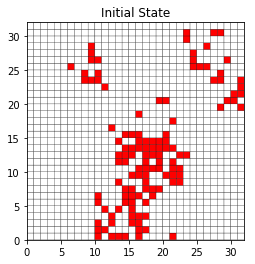

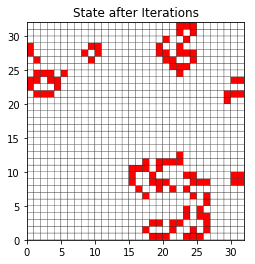

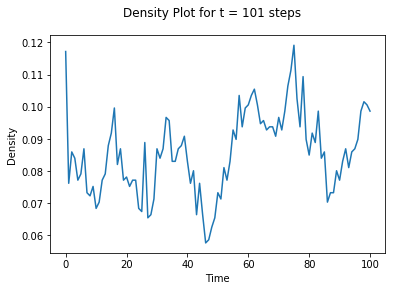

In [2]:
world = init_world(n = 32, cluster_n = 7, clusters = 10)
series = timeseries(world, 100)
plot_world(series[0], "Initial State")
plot_world(series[-1], "State after Iterations")
plot_density(series)

An important thing to note here is that the density of the model over time decreases, or at least doesn't grow explosively. This is a defining feature of the Game of Life in its standard form.

Now we add asynchronous updates by changing the timestep and timeseries functions. First, we change the timestep function by starting the new_state with a copy of the old world, then using the new_state to determing updates while subsequently updating the new_state and repeating for each square in the grid world.

In [3]:
#update rectilinearly
    
def timestep_async(world):
    rows = world.shape[0]
    cols = world.shape[1]
    
    new_state = world.copy()
    for x in range(0, rows):
        for y in range(0, cols):
            new_state[x,y] = update_cell(new_state, x, y)
            
    return new_state

def timeseries_async(world, num_steps):
    simulation_steps = [world]
    for i in range(0, num_steps):
        world = timestep_async(world)
        simulation_steps.append(world)

    return simulation_steps

Now we see a comparison between the original state, the world after 20 synchrounous updates, and after 20 asynchronous updates to get a good visual comparison of how the world behaves.

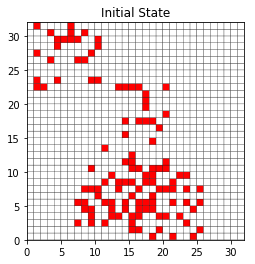

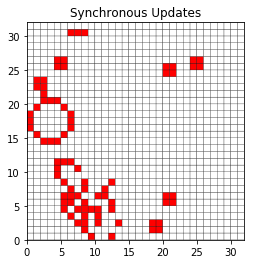

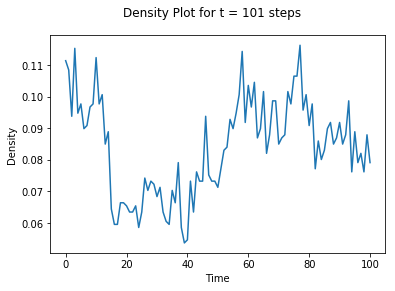

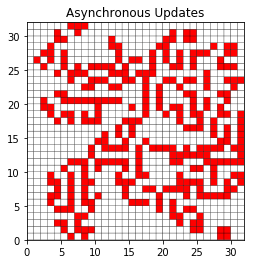

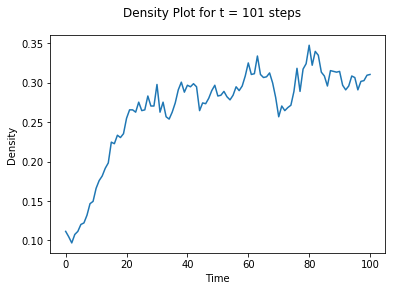

In [4]:
world = init_world(n = 32, cluster_n = 10, clusters = 5)
series = timeseries(world, 100)
series_async = timeseries_async(world, 100)
plot_world(world, "Initial State")
plot_world(series[-1], "Synchronous Updates")
plot_density(series)
plot_world(series_async[-1], "Asynchronous Updates")
plot_density(series_async)

From these graphs, we see that the synchronous updates created a grid with likely fewer live nodes, and more spatially grouped. The asynchronous updates grid however has many more live squares, and a maze-like pattern (lots of horizontal and vertical lines) has formed, showing a distinctly macroscopic organization of the live nodes. This concept relates to the last section of this tutorial, but we get a taste for self-organization here. Also noteworthy is that the density of live cells in the aynchronous grid world grows constantly, defeating the stability of the standard Game of Life.

## 2.2 Stochasticity

Most cellular automata are perfectly deterministic models, showing the natural progression of a system whose outcome is guaranteed the moment a starting state is chosen. While this model has many interesting properties that create deterministic emergent behaviors like spaceships (a formation that's unlikely with stochasticity), it may be an oversimplification of real populations. In the real world things happen with enough variables that a stochastic model may be a more realistic prediction of behaviors.

There are many ways to add stochasticity to our model, but one that fits well with asynchronous updates from before is to choose cells to update at random, allowing the model to grow and evolve in a much less rigid and organized way, mimicking the randomness a real population might experience. 

This new model is a much closer mimic of a real population than the original model, and we can examine its behavior in the exercise below.

To change our model to allow for random asynchronous updates, we take the asynchronous timestep and timeseries functions from before, except this time we change the way timestep operates. In this function, for the total number of squares there are in a grid-world, we choose a cell completely at random using python's random library, creating a random int within the row and column range and updating that cell. We update timeseries to call our new timestep function.

In [5]:
#update randomly
import random

def timestep_rasync(world):
    rows = world.shape[0]
    cols = world.shape[1]
    
    new_state = world.copy()
    for x in range(0, rows*cols):
        x = random.randint(0,rows-1)
        y = random.randint(0,cols-1)
        new_state[x,y] = update_cell(new_state, x, y)
            
    return new_state

def timeseries_rasync(world, num_steps):
    simulation_steps = [world]
    for i in range(0, num_steps):
        world = timestep_rasync(world)
        simulation_steps.append(world)

    return simulation_steps

Now we run a simulation using both asynchronous models we have developed so far. First we examine the initial state, then the world after rectilinear asynchronous updates, then random asynchronous updates.

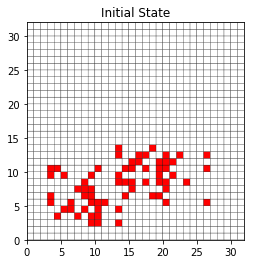

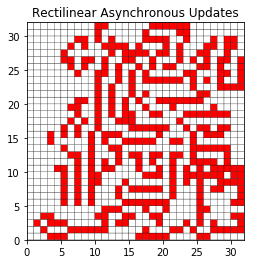

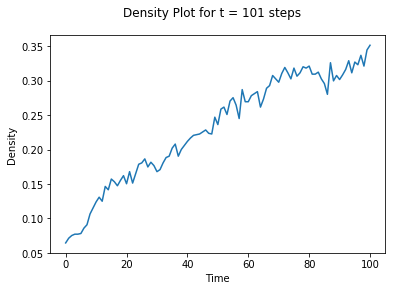

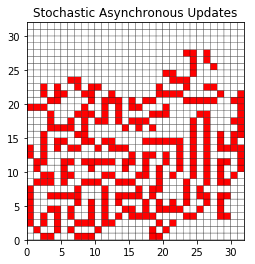

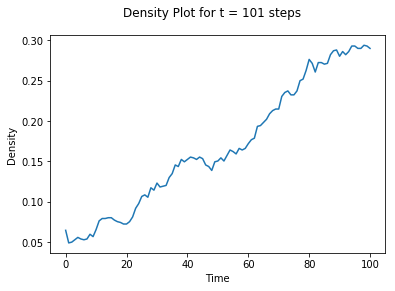

In [6]:
world = init_world(n = 32, cluster_n = 8, clusters = 5)
series_async = timeseries_async(world, 100)
series_rasync = timeseries_rasync(world, 100)
plot_world(world, "Initial State")
plot_world(series_async[-1], "Rectilinear Asynchronous Updates")
plot_density(series_async)
plot_world(series_rasync[-1], "Stochastic Asynchronous Updates")
plot_density(series_rasync)

Here we notice that the random updates tend to form a strikingly similar model to the asynchronous updates. However, the asynchronous model creates a visually smaller region of living cells, indicating that random updates may disrupt a pattern within the rectilinear updates that spreads more evenly across the grid space. Also, we again see that the densities of the asynchronous update grid worlds grow significantly over time, which if this continues forever, it could be a poor model of many real world populations that all have some carrying capacity.


## 2.3 Time To Live (TTL)

The cells in our first model in section 1 lived forever, which could be seen as somewhat unnatural. In reality all members of a population eventually die, so we can use a time-to-live component where if a cell is alive for too long, it dies. Here, we'll consider a cell going from DEAD to ALIVE resets the time to live, while decrementing a counter for each update a cell stays ALIVE.

To do this, we can simply replace the world array with the time to live values, making 0 be still DEAD, while any number greater than 0 indicates the ALIVE state. We need to decide on an initial time to live value, which we'll call START_TTL. This value can be adjusted to whichever value seems to produce the most interesting results. We have left this start value as 6 from our own experiments, but the interested reader is encouraged to play around with this value to examine how it affects the behavior of the model.

In [7]:
#time to live component
DEAD = 0
START_TTL = 6

def init_world_ttl(n = 16, cluster_n = 4, clusters = 3, threshold = 0.25):
    world = np.zeros((n, n), dtype=int)

    for i in range(0, clusters):
        x = random.randint(0, n - cluster_n)
        y = random.randint(0, n - cluster_n)
        for world_x in range(x, x + cluster_n):
            for world_y in range(y, y + cluster_n):
                if random.uniform(0, 1) >= (1 - threshold):
                    world[world_x, world_y] = START_TTL #change
    return world

def update_cell_ttl(world, x, y):
    num_alive = 0
    current_state = world[x,y]

    #count neighbors
    x_range = range(max(x - 1, 0), min(x + 1, world.shape[0] - 1) + 1)
    y_range = range(max(y - 1, 0), min(y + 1, world.shape[1] - 1) + 1)

    for cell_x, cell_y in product(x_range, y_range):
        if (not (cell_x, cell_y) == (x, y) and world[cell_x, cell_y] > DEAD):
            num_alive += 1

    if current_state == DEAD:
        if not num_alive == 3:
            return DEAD
        else:
            return START_TTL
    else:
        if num_alive != 2 and num_alive != 3:
            return DEAD
        else:
            return current_state - 1

def timestep_ttl(world):
    rows = world.shape[0]
    cols = world.shape[1]

    new_state = np.zeros((rows, cols), dtype=int)
    for x in range(0, rows):
        for y in range(0, cols):
            new_state[x,y] = update_cell_ttl(world, x, y)

    return new_state

def timeseries_ttl(world, num_steps):
    simulation_steps = [world]
    for i in range(0, num_steps):
        world = timestep_ttl(world)
        simulation_steps.append(world)

    return simulation_steps

Below, we test the model first showing the initial state, then the world after being updated according to the standard Game of Life, and finally after being updated according to the functions using a time to live value. Again, we encourage the reader to adjust the START_TTL value and rerun the cell below to examine different behaviors.

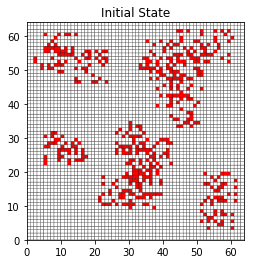

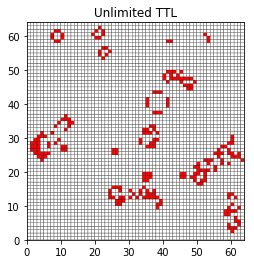

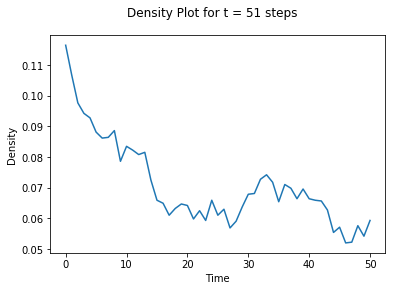

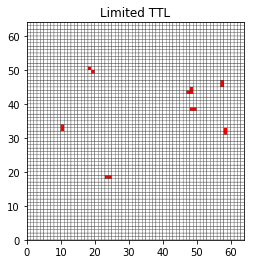

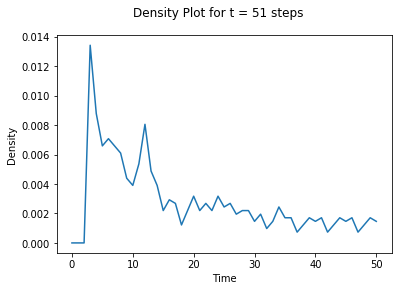

In [8]:
START_TTL = 4

world = init_world(n = 64, cluster_n = 10, clusters = 20)
world_ttl = init_world_ttl(n = 64, cluster_n = 10, clusters = 20)
series = timeseries(world, 50)
series_ttl = timeseries_ttl(world_ttl, 50)
plot_world(world, "Initial State")
plot_world(series[-1], "Unlimited TTL")
plot_density(series)
plot_world(series_ttl[-1], "Limited TTL")
plot_density(series_ttl)

Examining the output of the above graphs, we notice that with a large START_TTL, the output will be remarkably similar to the standard game of life. This is because if the time to live for a node is very high, it will take a long time for it to die any other way than Game of Life's normal lonliness or overcrowding. However, as the START_TTL is reduced towards a small number (4 or smaller), the grid world tends to lose all life. This is in contrast to the asynchronous update models which tend to grow explosively. Therefore, in the next section we combine these two in order to make an attempt at achieving a stable growth rate.

In [9]:
def timestep_async_ttl(world):
    rows = world.shape[0]
    cols = world.shape[1]
    
    new_state = world.copy()
    for x in range(0, rows):
        for y in range(0, cols):
            new_state[x,y] = update_cell_ttl(new_state, x, y)
            
    return new_state

def timeseries_async_ttl(world, num_steps):
    simulation_steps = [world]
    for i in range(0, num_steps):
        world = timestep_async_ttl(world)
        simulation_steps.append(world)

    return simulation_steps

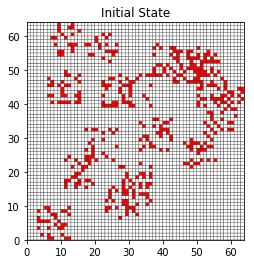

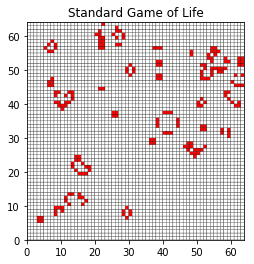

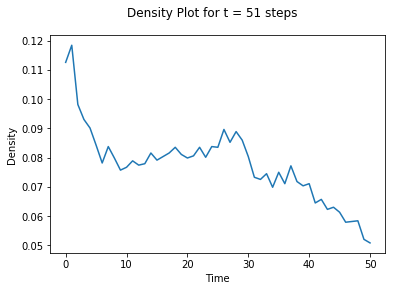

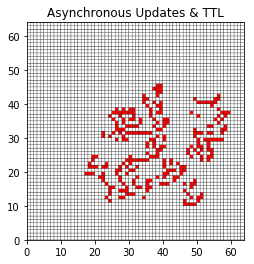

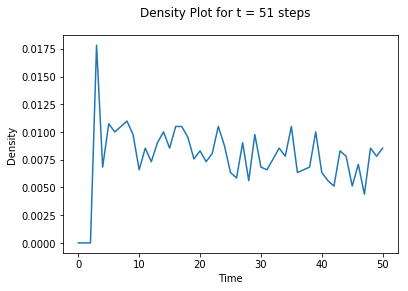

In [10]:
START_TTL = 4

world = init_world(n = 64, cluster_n = 10, clusters = 20)
world_ttl = init_world_ttl(n = 64, cluster_n = 10, clusters = 20)
series = timeseries(world, 50)
series_async_ttl = timeseries_async_ttl(world_ttl, 50)
plot_world(world, "Initial State")
plot_world(series[-1], "Standard Game of Life")
plot_density(series)
plot_world(series_async_ttl[-1], "Asynchronous Updates & TTL")
plot_density(series_async_ttl)

With the initial TTL value of 4, we achieve a mostly stable growth rate, similar to that of the standard Game of life. However, our resulting model has more properties similar to that of a real population, namely that cells don't live forever, and updates to cells influence all future updates asynchronously. 

## Part 2 Conclusion

These are only a few of the ways we can update the cellular automata model; there are many other ways to work with cellular automata that make them an exceptionally expressive model. For our purposes, it creates some interesting emergent behaviors as with the asynchronous updates and the resulting maze-like pattern, and the reader is encouraged to consider other ways the model could be changed to further explore its applications.